# Détection de la maturité des tomate

## importer les bibliothèques

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.7 MB/s eta 0:00:00


In [2]:
import os, shutil, glob, random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO, settings
import warnings

# DISABLE Ray Tune to fix the AttributeError
settings.update({'raytune': False})
warnings.filterwarnings('ignore')
print("Libraries imported & Ray Tune disabled.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Libraries imported & Ray Tune disabled.


## Exploration du dataset

In [3]:
# Define the dataset path based on the Kaggle input
dataset_path = "/kaggle/input/laboro-tomato"

# Find the dataset configuration file (.yaml)
yaml_files = glob.glob(f"{dataset_path}/*.yaml")
config_path = yaml_files[0] if yaml_files else None

print(f"Dataset Config Found: {config_path}")

Dataset Config Found: /kaggle/input/laboro-tomato/example_dataset.yaml


In [4]:
!ls /kaggle/input/laboro-tomato

annotations  example_dataset.yaml  train  val


In [5]:
import os

target_dir = "/kaggle/input/laboro-tomato"

for root, dirs, files in os.walk(target_dir):
    print(f"📂 {root}/")
    for f in files[:3]:  # Show only first 3 files to keep it clean
        print(f"   📄 {f}")
    if len(files) > 3:
        print(f"   ... ({len(files) - 3} more files)")

📂 /kaggle/input/laboro-tomato/
   📄 example_dataset.yaml
📂 /kaggle/input/laboro-tomato/annotations/
   📄 train.json
   📄 test.json
📂 /kaggle/input/laboro-tomato/val/
📂 /kaggle/input/laboro-tomato/val/labels/
   📄 IMG_20191215_112718.txt
   📄 IMG_1085.txt
   📄 IMG_20191215_111957.txt
   ... (158 more files)
📂 /kaggle/input/laboro-tomato/val/images/
   📄 IMG_1025.jpg
   📄 IMG_20191215_111407.jpg
   📄 IMG_1035.jpg
   ... (158 more files)
📂 /kaggle/input/laboro-tomato/train/
📂 /kaggle/input/laboro-tomato/train/labels/
   📄 IMG_20191215_111230.txt
   📄 IMG_1292.txt
   📄 IMG_20191215_112509.txt
   ... (640 more files)
📂 /kaggle/input/laboro-tomato/train/images/
   📄 IMG_20191215_111806.jpg
   📄 IMG_20191215_111654.jpg
   📄 IMG_20191215_111114.jpg
   ... (640 more files)


In [7]:
import os

base_dir = "/kaggle/input/laboro-tomato"

# Vérifier train, test et val (si présents)
for split in ['train', 'val']:
    img_path = os.path.join(base_dir, split, 'images')
    if os.path.exists(img_path):
        count = len(os.listdir(img_path))
        print(f"📁 {split.upper()} : {count} images")
    else:
        print(f"⚠️ Le dossier '{split}' n'a pas été trouvé.")

📁 TRAIN : 643 images
📁 VAL : 161 images


## Visualisation

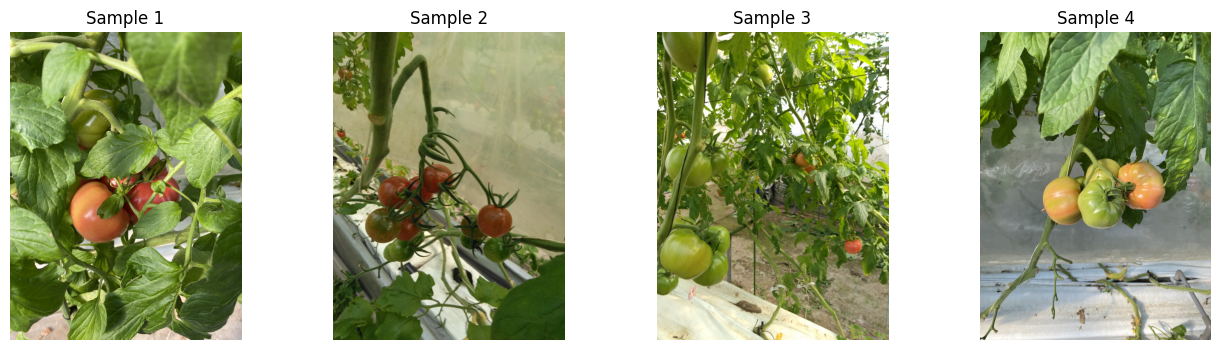

In [8]:
import os, random
import cv2
import matplotlib.pyplot as plt

# Path to training images
train_dir = "/kaggle/input/laboro-tomato/train/images"

# Pick 4 random images
random_files = random.sample(os.listdir(train_dir), 4)

# Create a figure to display them
plt.figure(figsize=(16, 4))

for i, file_name in enumerate(random_files):
    # Read image
    img_path = os.path.join(train_dir, file_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for correct colors
    
    # Plot
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Sample {i+1}")

plt.show()

## Chargement de YOLO

In [9]:
# Load the Medium model (yolov8m.pt)
model = YOLO('yolov8m.pt') 

print("Model loaded (Medium). Classes:", model.names)

Model loaded (Medium). Classes: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard

## fine-tunning du modèle YOLO

In [10]:
import yaml

# Load original broken config
with open(config_path, 'r') as f:
    data = yaml.safe_load(f)

# Overwrite with correct Kaggle paths
data['path'] = dataset_path  # /kaggle/input/laboro-tomato
data['train'] = "train/images"
data['val'] = "val/images"

# Save as a new file
new_yaml = "/kaggle/working/tomato_fixed.yaml"
with open(new_yaml, 'w') as f:
    yaml.dump(data, f)

print(f"Fixed config saved to: {new_yaml}")

Fixed config saved to: /kaggle/working/tomato_fixed.yaml


In [11]:
# Train using the FIXED configuration
model.train(
    data=new_yaml,    # Use the new corrected file
    epochs=50,
    imgsz=640,
    batch=16,
    name='tomato_run_fixed'
)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/tomato_fixed.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=tomato_run_fixed, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspec

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bc22d0e1460>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

## Résultat

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the results file (update 'tomato_run_fixed3' if needed)
csv_path = '/kaggle/working/runs/detect/tomato_run_fixed/results.csv'

# Read CSV and clean column names (remove extra spaces)
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()

print(f"Loaded training data from {len(df)} epochs.")

Loaded training data from 50 epochs.


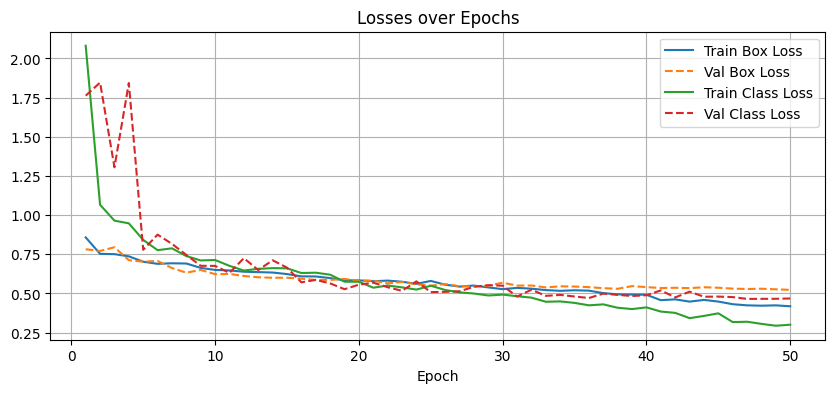

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', linestyle='--')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss', linestyle='--')

plt.title("Losses over Epochs"); plt.xlabel("Epoch"); plt.legend()
plt.grid(True); plt.show()

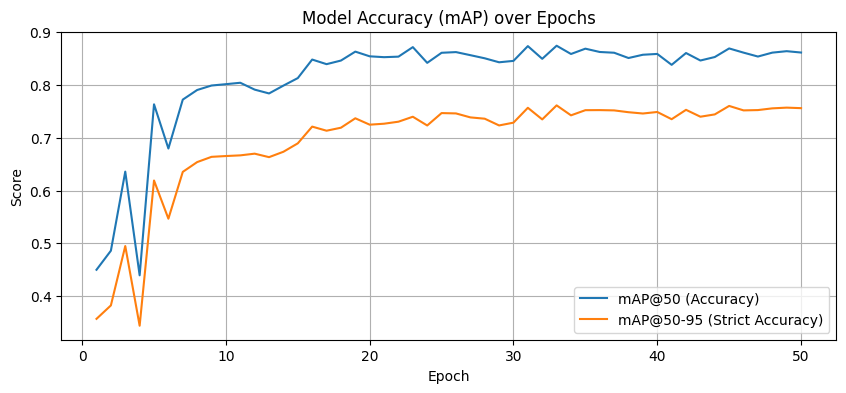

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50 (Accuracy)')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95 (Strict Accuracy)')

plt.title("Model Accuracy (mAP) over Epochs"); plt.xlabel("Epoch"); plt.ylabel("Score")
plt.legend(); plt.grid(True); plt.show()

In [16]:
# Get the last row of data (final epoch)
final = df.iloc[-1]

print("🚀 Final Results:")
print(f"Precision: {final['metrics/precision(B)']:.3f}")
print(f"Recall:    {final['metrics/recall(B)']:.3f}")
print(f"mAP@50:    {final['metrics/mAP50(B)']:.3f}")

🚀 Final Results:
Precision: 0.828
Recall:    0.797
mAP@50:    0.862


## Tester le modèle

In [20]:
from ultralytics import YOLO
import os, random

# Load the trained model
model = YOLO('/kaggle/working/runs/detect/tomato_run_fixed/weights/best.pt')

# 👇 REPLACE THIS with the path to your specific image
# For now, I'm picking a random one from the validation set
val_dir = "/kaggle/input/laboro-tomato/val/images"
image_path = os.path.join(val_dir, random.choice(os.listdir(val_dir)))

print(f"Testing on: {image_path}")

Testing on: /kaggle/input/laboro-tomato/val/images/IMG_1179.jpg



image 1/1 /kaggle/input/laboro-tomato/val/images/IMG_1179.jpg: 640x480 10 l_greens, 14.7ms
Speed: 3.1ms preprocess, 14.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


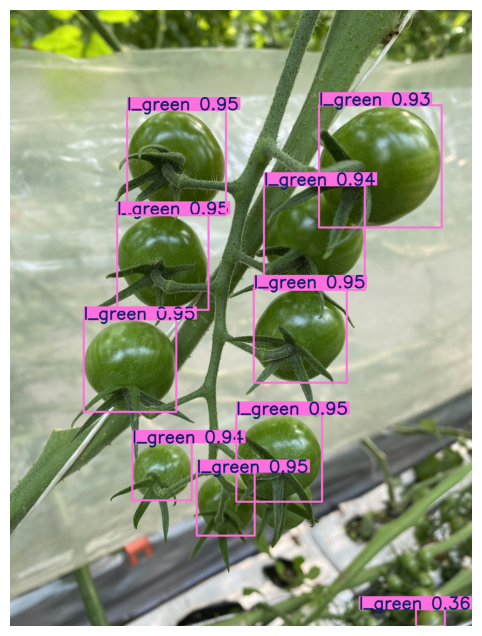

In [21]:
import cv2
import matplotlib.pyplot as plt

# Run prediction
results = model.predict(image_path)
plotted_img = results[0].plot() # Draw boxes

# Display
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB))
plt.axis('off'); plt.show()